<a href="https://colab.research.google.com/github/OneMediCo/alan-ml-model/blob/main/detect_cataract_with_gpt_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow import nn, multiply
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Reshape, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data_dir = '/content/drive/MyDrive/Alan/CataractData/EyeImagesTakenFromCamera2'
train_data_dir = data_dir + '/Train/'
# Define image directories
cataract_dir = data_dir + '/Train/Cataract/'
normal_dir = data_dir + '/Train/Normal/'

In [4]:
from tensorflow.keras import layers

class SEBlock(layers.Layer):
    def __init__(self, reduction=16):
        super(SEBlock, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        channels = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D()
        self.expand1 = layers.Dense(channels // self.reduction, activation='relu')
        self.expand2 = layers.Dense(channels, activation='sigmoid')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x = self.expand1(x)
        x = self.expand2(x)
        return layers.multiply([inputs, x])


In [8]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(gray_image):
    # Step 1: Thresholding to create a binary mask
    _, binary_mask = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY)

    # Step 2: Dilating the binary mask
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(binary_mask, kernel, iterations=1)

    # Step 3: Inpainting to fill in the glare regions
    mask = np.uint8(dilated)
    result = cv2.inpaint(gray_image, mask, 3, cv2.INPAINT_NS)

    # Reshape result to (height, width, 1)
    result = np.expand_dims(result, axis=-1)

    return result



missing_files_counter = 0
def ignore_if_file_not_found(gen):
  while True:
    try:
      data, labels = next(gen)
      yield data, labels
    except:
      missing_files_counter += 1

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,  # Your preprocessing function
    validation_split=0.2,  # Reserve 20% of the data for validation
)

# Create a training data generator
train_gen = datagen.flow_from_directory(
    directory=train_data_dir,  # The directory where your images are
    target_size=(512, 512),  # The target image size
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='binary',  # For binary classification
    batch_size=10,  # The number of images to generate per batch
    subset='training'  # This is the training set
)

# Create a validation data generator
val_gen = datagen.flow_from_directory(
    directory=train_data_dir,  # The directory where your images are
    target_size=(512, 512),  # The target image size
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='binary',  # For binary classification
    batch_size=10,  # The number of images to generate per batch
    subset='validation'  # This is the validation set
)


Found 6528 images belonging to 2 classes.
Found 1631 images belonging to 2 classes.


In [6]:
# Define the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(512, 512, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(SEBlock(128))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [7]:
model.fit(train_gen, validation_data=val_gen, epochs=10, batch_size=10)

Epoch 1/10
653/653 [==============================] - 1382s 2s/step - loss: 3.7586 - accuracy: 0.6924 - val_loss: 0.5623 - val_accuracy: 0.7321
Epoch 2/10
653/653 [==============================] - 875s 1s/step - loss: 0.5551 - accuracy: 0.7405 - val_loss: 0.5884 - val_accuracy: 0.7155
Epoch 3/10
653/653 [==============================] - 879s 1s/step - loss: 0.4597 - accuracy: 0.7996 - val_loss: 0.6477 - val_accuracy: 0.7431
Epoch 4/10
653/653 [==============================] - 876s 1s/step - loss: 0.3824 - accuracy: 0.8415 - val_loss: 0.6176 - val_accuracy: 0.7265
Epoch 5/10
653/653 [==============================] - 880s 1s/step - loss: 0.2807 - accuracy: 0.8876 - val_loss: 0.8056 - val_accuracy: 0.7431
Epoch 6/10
653/653 [==============================] - 880s 1s/step - loss: 0.2685 - accuracy: 0.9079 - val_loss: 1.0516 - val_accuracy: 0.7406
Epoch 7/10
653/653 [==============================] - 873s 1s/step - loss: 0.3207 - accuracy: 0.8989 - val_loss: 0.8652 - val_accuracy: 0.745

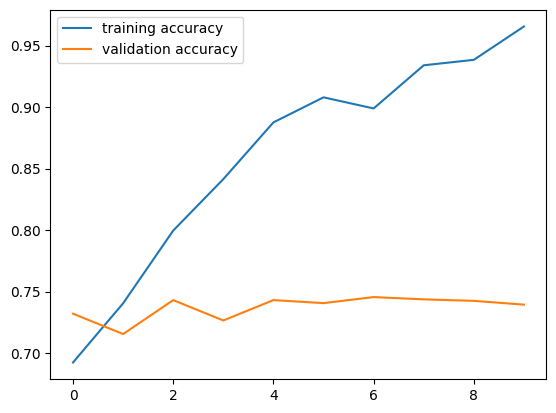

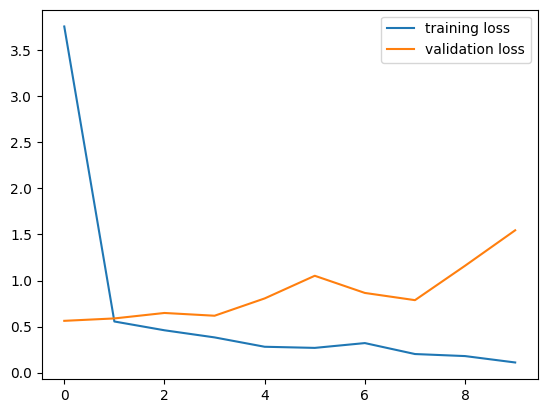

In [8]:
import matplotlib.pyplot as plt
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [5]:
import datetime
import os

MODEL_DIR = '/content/drive/MyDrive/Alan/Model'
version = int(datetime.datetime.now().timestamp())
export_path = os.path.join(MODEL_DIR, 'gpt-4-detect-cataract-0.1-' + str(version))
print('export_path = {}\n'.format(export_path))

keras.models.save_model(
    model,
    export_path
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /content/drive/MyDrive/Alan/Model/gpt-4-detect-cataract-0.1-1689524565



NameError: ignored

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow import nn, multiply
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Reshape, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def predict_eye_condition(image_path, model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    #image = preprocess_image(image)
    #image = cv2.resize(image, (512, 512))

    # Keras models expect batches of images, so we have to add a dimension to the image
    #image = np.expand_dims(image, axis=0)

    # Use the model to predict the image's label
    prediction = model.predict(image)

    # Output the result
    if prediction < 0.5:
        print('The model predicts this image is a normal eye.')
    else:
        print('The model predicts this image is an eye with cataract.')

from tensorflow import expand_dims
def predict_cataract_or_not(image_path, model):
  img = keras.utils.load_img(
      image_path, target_size=(512,512)
  )
  img_array = keras.utils.img_to_array(img)
  img_array = expand_dims(img_array, 0)
  # model = tensorflow.keras.models.load_model('/content/drive/MyDrive/Alan/Model/verify-cataract-0.11-1687807308')
  predictions = model.predict(img_array)
  return 'normal' if predictions[0][0] == 1 else 'cataract'

In [9]:
test_data_dir = data_dir + '/Test'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_set = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(512, 512),  # The target image size
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='binary',  # For binary classification
    batch_size=1,  # The number of images to generate per batch
)

loaded_model = keras.models.load_model(MODEL_DIR + '/gpt-4-detect-cataract-0.1-1689497097/')
predictions = loaded_model.predict(test_set)



Found 200 images belonging to 2 classes.
200/200 [==============================] - 35s 172ms/step


In [10]:
import pandas as pd
predicted_class_indices = [1 if float(p[0]) > 0.5 else 0 for p in predictions]
labels = (test_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds = [labels[k] for k in predicted_class_indices]
results=pd.DataFrame({"File":test_set.filenames,
                      "Predictions":preds})
print(results)
test_matches = [1 if results['Predictions'][ind] in results['File'][ind] else 0 for ind in results.index]
print('Test matches', float(sum(test_matches)/len(test_matches)))




                        File Predictions
0    Cataract/cat_0_1981.jpg    Cataract
1    Cataract/cat_0_1984.jpg    Cataract
2    Cataract/cat_0_1987.jpg      Normal
3    Cataract/cat_0_1988.jpg      Normal
4    Cataract/cat_0_1989.jpg      Normal
..                       ...         ...
195    Normal/cat_0_1925.jpg      Normal
196    Normal/cat_0_1928.jpg    Cataract
197    Normal/cat_0_1930.jpg      Normal
198    Normal/cat_0_1931.jpg    Cataract
199    Normal/cat_0_1937.jpg      Normal

[200 rows x 2 columns]
Test matches 0.52


In [13]:
matching = 0
normal_matching = 0
cataract_matching = 0
for image_path, prediction in predictions.items():
  if (image_path.startswith('/content/drive/MyDrive/Alan/CataractData/EyeImagesTakenFromCamera2/Test/Normal') and prediction == 'normal'):
    normal_matching += 1
  if (image_path.startswith('/content/drive/MyDrive/Alan/CataractData/EyeImagesTakenFromCamera2/Test/Cataract') and prediction == 'cataract'):
    cataract_matching += 1

matching = normal_matching + cataract_matching
print('------------ Overall ---------------')
print(matching, 'out of', len(predictions))
print(matching/len(predictions))
print('---------------- Normal --------------')
print(normal_matching, 'out of', int(len(predictions)/2))
print(normal_matching/(len(predictions)/2))
print('---------------- Cataract --------------')
print(cataract_matching, 'out of', int(len(predictions)/2))
print(cataract_matching/(len(predictions)/2))

AttributeError: ignored